In [176]:
import os
import cv2
import numpy as np
import skimage.measure
from skimage import feature
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim

In [227]:
def correlations(intensities):
    x1h = intensities
    x2h = np.zeros([height, width])
    for i in range(0, height):
        for j in range(0, width-1):
            x2h[i][j] = x1h[i][j+1]
        x2h[i][width-1] = x1h[i][width-1]

    total_N = np.size(x1h)
    mean_x1h = x1h.sum()/total_N
    mean_x2h = x2h.sum()/total_N

    aa1 = (x1h - mean_x1h)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2h - mean_x2h)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1h - mean_x1h)*(x2h - mean_x2h)
    hcov = cc.sum()/total_N

    hcorr = hcov/(std_dev1 * std_dev2)
#     print('hcorr', hcorr)

    # Vertical correlation
    x1v = intensities
    x2v = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width):
            x2v[i][j] = x1v[i+1][j]
            x2v[height-1][j] = x1v[height-1][j]

    total_N = np.size(x1v)
    mean_x1v = x1v.sum()/total_N
    mean_x2v = x2v.sum()/total_N

    aa1 = (x1v - mean_x1v)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2v - mean_x2v)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1v - mean_x1v)*(x2v - mean_x2v)
    vcov = cc.sum()/total_N

    vcorr = vcov/(std_dev1 * std_dev2)
#     print('vcorr',vcorr)

    # Diagonal correlation
    x1d = intensities
    x2d = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width-1):
            x2d[i][j] = x1d[i+1][j+1]
            x2d[height-1][j] = x1d[height-1][j]
        x2d[i][width-1] = x1d[i][width-1]
    x2d[height-1][width-1] = x1d[height-1][width-1]

    total_N = np.size(x1d)
    mean_x1d = x1d.sum()/total_N
    mean_x2d = x2d.sum()/total_N

    aa1 = (x1d - mean_x1d)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2d - mean_x2d)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1d - mean_x1d)*(x2d - mean_x2d)
    dcov = cc.sum()/total_N

    dcorr = dcov/(std_dev1 * std_dev2)
#     print('dcorr',dcorr)
    
    return hcorr, vcorr, dcorr

In [178]:
def eve_distortion(eve_intensities): #from the reconstructed image in uint8 type
    feve_intensities = eve_intensities.astype(np.float)
    fintensities = intensities.astype(np.float)
    dif = (fintensities -  feve_intensities)
    eve_dist_mat = dif**2
    occurance_sum = height*width #?!
    eve_dist = eve_dist_mat.sum()/occurance_sum
    return eve_dist

# Pairing

In [182]:
pairs1 = np.arange(0,128,1)

th = 20 #threshold
pairing_rounds = np.floor(th/2)
pairs2 = []
for j in range(int(pairing_rounds)):
    n = int((255-128-(2*j+1))/th)
    for i in range(n+1):
        pairs2 = np.append(pairs2,128+2*j+i*th)
        pairs2 = np.append(pairs2,128+2*j+1+i*th)
    if (128+2*j+(n+1)*th) <= 255:
        pairs2 = np.append(pairs2, 128+2*j+(n+1)*th)

if np.mod(th,2):
    n = int((255-128-(th-1))/th)# 128+4+n*th =<255
    for i in range(n+1):
        pairs2 = np.append(pairs2,128+th-1+i*th)     

num_paired = np.size(pairs2)
num_remained = 128 - num_paired

print(128/pairing_rounds)

12.8


In [88]:
128/pairing_rounds # th = 20

12.8

In [90]:
128/pairing_rounds # th = 10

25.6

In [127]:
pairs1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [128]:
pairs2 # th = 200

array([128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.,
       161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 179., 180., 181., 182.,
       183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193.,
       194., 195., 196., 197., 198., 199., 200., 201., 202., 203., 204.,
       205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226.,
       227., 228., 229., 230., 231., 232., 233., 234., 235., 236., 237.,
       238., 239., 240., 241., 242., 243., 244., 245., 246., 247., 248.,
       249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259.,
       260., 261., 262., 263., 264., 265., 266., 267., 268., 269., 270.,
       271., 272., 273., 274., 275., 276., 277., 27

In [135]:
pairs2 #th = 16

array([128., 129., 144., 145., 160., 161., 176., 177., 192., 193., 208.,
       209., 224., 225., 240., 241., 130., 131., 146., 147., 162., 163.,
       178., 179., 194., 195., 210., 211., 226., 227., 242., 243., 132.,
       133., 148., 149., 164., 165., 180., 181., 196., 197., 212., 213.,
       228., 229., 244., 245., 134., 135., 150., 151., 166., 167., 182.,
       183., 198., 199., 214., 215., 230., 231., 246., 247., 136., 137.,
       152., 153., 168., 169., 184., 185., 200., 201., 216., 217., 232.,
       233., 248., 249., 138., 139., 154., 155., 170., 171., 186., 187.,
       202., 203., 218., 219., 234., 235., 250., 251., 140., 141., 156.,
       157., 172., 173., 188., 189., 204., 205., 220., 221., 236., 237.,
       252., 253., 142., 143., 158., 159., 174., 175., 190., 191., 206.,
       207., 222., 223., 238., 239., 254., 255.])

In [130]:
pairs2 # th =100

array([128., 129., 228., 229., 130., 131., 230., 231., 132., 133., 232.,
       233., 134., 135., 234., 235., 136., 137., 236., 237., 138., 139.,
       238., 239., 140., 141., 240., 241., 142., 143., 242., 243., 144.,
       145., 244., 245., 146., 147., 246., 247., 148., 149., 248., 249.,
       150., 151., 250., 251., 152., 153., 252., 253., 154., 155., 254.,
       255., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 216., 217., 218., 219., 220.,
       221., 222., 223., 224., 225., 226., 227.])

# Information of Original Image

In [228]:
img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
imf = np.float32(intensities)
height = np.shape(imf)[0]
width = np.shape(imf)[1]

# #Quality Assessment 
# #distortion
# dist_dB = 10*np.log10(eve_distortion(eve_msb0_uint8))
# print('dist_dB:', dist_dB)
# #SSIM
# (ssim, diff) = compare_ssim(intensities, eve_msb0_uint8, full=True)
# print('ssim: ', ssim)

#Statistical Assessment
#corrolation
hcorr_org = correlations(intensities)[0]
print('hcorr_org: ', hcorr_org)
#entropy
entropy_org = skimage.measure.shannon_entropy(intensities)
print('entropy_org: ', entropy_org)

#edges
org_edges = cv2.Canny(intensities,100,130)
org_edges_uint8 = org_edges.astype(np.uint8)
cv2.imshow('org_edges', org_edges_uint8)
filename = 'org_edges.png'
cv2.imwrite(filename, org_edges_uint8)
cv2.waitKey(1000)
cv2.destroyAllWindows()

hcorr_org:  0.9720025058717428
entropy_org:  7.445061352834159


# Simple Threshold

In [183]:
#eve_msb0
eve_msb0 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):

        if imf[i,j] in pairs1:
            pos = np.argwhere(pairs1 == imf[i,j])

            if np.mod(pos,2):
                eve_msb0_element = pairs2[pos]
            else:
                eve_msb0_element = imf[i,j]

            eve_msb0[i,j] = eve_msb0_element


        if imf[i,j] in pairs2:
            pos = np.argwhere(pairs2 == imf[i,j])

            if np.mod(pos,2):
                eve_msb0_element = imf[i,j]
            else:
                eve_msb0_element = pairs1[pos]

            eve_msb0[i,j] = eve_msb0_element


eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0th'+str(th)+'.png'
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

# Metrics

In [229]:
# metrics, th = 20

#Quality Assessment 
#distortion
dist_dB = 10*np.log10(eve_distortion(eve_msb0_uint8))
print('dist_dB:', dist_dB)
#SSIM
(ssim, diff) = compare_ssim(intensities, eve_msb0_uint8, full=True)
print('ssim: ', ssim)

#Statistical Assessment
#corrolation
hcorr = correlations(eve_msb0_uint8)[0]
print('hcorr: ', hcorr)
#entropy
entropy = skimage.measure.shannon_entropy(eve_msb0_uint8)
print('entropy: ', entropy)

#Visual Security
#edge differece
#edges
eve_edges = cv2.Canny(eve_msb0_uint8,100,130)
eve_edges_uint8 = eve_edges.astype(np.uint8)
cv2.imshow('eve_edges', eve_edges_uint8)
filename = 'edges_th'+str(th)+'.png'
cv2.imwrite(filename, eve_edges_uint8)
cv2.waitKey(1000)
cv2.destroyAllWindows()

forg_edges = org_edges.astype(np.float)
feve_edges = eve_edges.astype(np.float)
edge_diff = forg_edges - feve_edges
edge_diff_dB = 10*np.log10(sum(sum(edge_diff**2)))
print('edge_difference_dB: ',edge_diff_dB)

dist_dB: 38.31690338108657
ssim:  0.01321466953848205
hcorr:  0.08217060631613589
entropy:  6.779024124357903
edge_difference_dB:  98.1918255585971


In [118]:
10*np.log10(eve_distortion(eve_msb0_uint8)) # th = 128

39.17800802907113

In [119]:
#eve_msb1
img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
imf = np.float32(intensities)
height = np.shape(imf)[0]
width = np.shape(imf)[1]

eve_msb1 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):

        if imf[i,j] in pairs1:
            pos = np.argwhere(pairs1 == imf[i,j])

            if not np.mod(pos,2):
                eve_msb1_element = pairs2[pos]
            else:
                eve_msb1_element = imf[i,j]

            eve_msb1[i,j] = eve_msb1_element


        if imf[i,j] in pairs2:
            pos = np.argwhere(pairs2 == imf[i,j])

            if not np.mod(pos,2):
                eve_msb1_element = imf[i,j]
            else:
                eve_msb1_element = pairs1[pos]

            eve_msb1[i,j] = eve_msb1_element

eve_msb1_uint8 =eve_msb1.astype(np.uint8)
cv2.imshow('eve_msb1', eve_msb1_uint8)
filename = 'eve_msb1th'+str(th)+'.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb1_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

In [50]:
10*np.log10(eve_distortion(eve_msb1_uint8)) # th = 20

38.21976653177969

In [120]:
10*np.log10(eve_distortion(eve_msb1_uint8)) # th = 128

39.08933825944088

In [ ]:
# Not Alternate MSB 0 to test the effect of thresholds
# Without Alternate MSB 0, this coding and thresholds does not have meaning

In [133]:
# track what happens for sequential intensities

input_int = list(range(0,10))

output_msb0 = np.zeros(np.shape(input_int)[0])
for i in range(np.shape(input_int)[0]):
    if input_int[i] in pairs1:
        pos = np.argwhere(pairs1 == input_int[i])

        if np.mod(pos,2):
            output_msb0_element = pairs2[pos]
        else:
            output_msb0_element = input_int[i]

        output_msb0[i] = output_msb0_element


    if input_int[i] in pairs2:
        pos = np.argwhere(pairs2 == input_int[i])

        if np.mod(pos,2):
            output_msb0_element = input_int[i]
        else:
            output_msb0_element = pairs1[pos]

        output_msb0[i] = output_msb0_element
        
        
output_msb1 = np.zeros(np.shape(input_int)[0])
for i in range(np.shape(input_int)[0]):
    if input_int[i] in pairs1:
        pos = np.argwhere(pairs1 == input_int[i])

        if not np.mod(pos,2):
            output_msb1_element = pairs2[pos]
        else:
            output_msb1_element = input_int[i]

        output_msb1[i] = output_msb1_element


    if input_int[i] in pairs2:
        pos = np.argwhere(pairs2 == input_int[i])

        if np.mod(pos,2):
            output_msb1_element = input_int[i]
        else:
            output_msb1_element = pairs1[pos]

        output_msb1[i] = output_msb1_element

In [112]:
print(input_int)   # th = 100     
print(output_msb0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[  0. 129.   2. 229.   4. 131.   6. 231.   8. 133.]


In [132]:
print(input_int)   # th = 100     
print(output_msb0)

[246, 247, 248, 249, 250, 251, 252, 253, 254, 255]
[ 38. 247.  42. 249.  46. 251.  50. 253.  54. 255.]


In [122]:
print(input_int)   # th = 128     
print(output_msb0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[  0. 129.   2. 131.   4. 133.   6. 135.   8. 137.]


In [124]:
print(input_int)   # th = 128     
print(output_msb0)

[246, 247, 248, 249, 250, 251, 252, 253, 254, 255]
[118. 247. 120. 249. 122. 251. 124. 253. 126. 255.]


In [109]:
print(input_int)   # th = 16     
print(output_msb0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[  0. 129.   2. 145.   4. 161.   6. 177.   8. 193.]


In [107]:
print(input_int)   # th = 16     
print(output_msb0)

[245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
[245.  62. 247.  78. 249.  94. 251. 110. 253. 126.]


In [93]:
print(input_int)   # th = 10     
print(output_msb0)

[245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
[245. 126. 247.  24. 249.  50. 251.  76. 253. 102.]


In [70]:
print(input_int)        
print(output_msb0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[  0. 129.   2. 149.   4. 169.   6. 189.   8. 209.]


In [75]:
print(input_int)        
print(output_msb1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[128.   1. 148.   3. 168.   5. 188.   7. 208.   9.]


In [77]:
print(input_int)        
print(output_msb0)

[128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
[  0. 129.  14. 131.  28. 133.  42. 135.  56. 137.]


In [78]:
print(input_int)        
print(output_msb1)

[128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
[  0. 129.  14. 131.  28. 133.  42. 135.  56. 137.]


In [80]:
print(input_int)        
print(output_msb0)

[117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
[147. 118. 167. 120. 187. 122. 207. 124. 227. 126.]


In [81]:
print(input_int)        
print(output_msb1)

[117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
[117. 166. 119. 186. 121. 206. 123. 226. 125. 246.]


In [84]:
print(input_int)        
print(output_msb0)

[245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
[245. 126. 247.  12. 249.  26. 251.  40. 253.  54.]


In [85]:
print(input_int)        
print(output_msb1)

[245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
[245. 126. 247.  12. 249.  26. 251.  40. 253.  54.]


In [138]:
# NB
eve_msb0 = imf
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):
        if imf[i,j] >= 128:
            eve_msb0[i,j] = imf[i,j]-128

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_NB.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

# Position based Coding

In [31]:
# different coding in different positions

#wihtout threshold, black NB, white MSB reverse NB
#horizontal
eve_msb0 = imf.copy()
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):
        if not np.mod(i,2):
            if imf[i,j] >= 128:
                eve_msb0[i,j] = imf[i,j]-128
                
        if np.mod(i,2):
            if imf[i,j] <= 128:
                eve_msb0[i,j] = imf[i,j]+128

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_horizontal_position.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

#vertical
eve_msb0 = imf.copy()
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):
        if not np.mod(j,2):
            if imf[i,j] >= 128:
                eve_msb0[i,j] = imf[i,j]-128
                
        if np.mod(j,2):
            if imf[i,j] <= 128:
                eve_msb0[i,j] = imf[i,j]+128

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_vertical_position.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

#chessboard
#eve_msb0
eve_msb0 = imf.copy()
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):
        if not np.mod(i+j,2):
            if imf[i,j] >= 128:
                eve_msb0[i,j] = imf[i,j]-128
                
        if np.mod(i+j,2):
            if imf[i,j] <= 128:
                eve_msb0[i,j] = imf[i,j]+128

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_chess.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

In [158]:
#different coding in different positions
#with threshold = 20
#chessboard

#eve_msb0
eve_msb0 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
for i in range(np.shape(imf)[0]):
    for j in range(np.shape(imf)[1]):
        if not np.mod(i+j,2):
            if imf[i,j] in pairs1:
                pos = np.argwhere(pairs1 == imf[i,j])

                if np.mod(pos,2):
                    eve_msb0_element = pairs2[pos]
                else:
                    eve_msb0_element = imf[i,j]

                eve_msb0[i,j] = eve_msb0_element


            if imf[i,j] in pairs2:
                pos = np.argwhere(pairs2 == imf[i,j])

                if np.mod(pos,2):
                    eve_msb0_element = imf[i,j]
                else:
                    eve_msb0_element = pairs1[pos]

                eve_msb0[i,j] = eve_msb0_element
                
                
        if np.mod(i+j,2):
            if imf[i,j] in pairs1:
                pos = np.argwhere(pairs1 == imf[i,j])

                if not np.mod(pos,2):
                    eve_msb0_element = pairs2[pos]
                else:
                    eve_msb0_element = imf[i,j]

                eve_msb0[i,j] = eve_msb0_element


            if imf[i,j] in pairs2:
                pos = np.argwhere(pairs2 == imf[i,j])

                if not np.mod(pos,2):
                    eve_msb0_element = imf[i,j]
                else:
                    eve_msb0_element = pairs1[pos]

                eve_msb0[i,j] = eve_msb0_element


# imf_uint8 =imf.astype(np.uint8)
# cv2.imshow('original', imf_uint8)
# filename = 'original.webp'
# cv2.imwrite(filename, imf_uint8)
# cv2.waitKey(1000)

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_position_th_'+str(th)+'.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

cv2.destroyAllWindows()

In [159]:
10*np.log10(eve_distortion(eve_msb0_uint8)) # th = 20

38.26264303881971

In [160]:
correlations(eve_msb0_uint8)

hcorr 0.0760723569589402
vcorr 0.08296723194782163
dcorr 0.07925836670564376


(0.0760723569589402, 0.08296723194782163, 0.07925836670564376)

In [42]:
##different coding in different blocks
#chessboard_test
# eve_msb0 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
eve_msb0 = imf.copy()
b_size = 8
for ii in range(0, int(height/b_size)):
    for jj in range(0, int(width/b_size)):
        if np.mod(ii+jj,2):
            for i in range(ii*b_size,(ii+1)*b_size):
                for j in range(jj*b_size,(jj+1)*b_size):
                    eve_msb0[i,j] = 0

eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_block_test1.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)
cv2.destroyAllWindows()

# Position based-Block-Just NB and RNB

In [80]:
#chessboard
#Just NB and reverse NB in different blocks

for k in range(0,10):
    b_size = 2**k
    eve_msb0 = imf.copy()
    for ii in range(0, int(height/b_size)):
        for jj in range(0, int(width/b_size)):
            if not np.mod(ii+jj,2):
                for i in range(ii*b_size,(ii+1)*b_size):
                    for j in range(jj*b_size,(jj+1)*b_size):
                        if imf[i,j] >= 128:
                            eve_msb0[i,j] = imf[i,j]-128

            else:
                for i in range(ii*b_size,(ii+1)*b_size):
                    for j in range(jj*b_size,(jj+1)*b_size):
                        if imf[i,j] <= 128:
                            eve_msb0[i,j] = imf[i,j]+128

    eve_msb0_uint8 =eve_msb0.astype(np.uint8)
    cv2.imshow('eve_msb0', eve_msb0_uint8)
    filename = 'eve_msb0_block_NBRNB_b'+str(b_size)+'.png'
    # cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
    cv2.imwrite(filename, eve_msb0_uint8)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()
    
    #Distortion
    dist_dB = 10*np.log10(eve_distortion(eve_msb0_uint8))
    #Corrolations
    hcorr = correlations(eve_msb0_uint8)[0]
    #Entropy
    entropy = skimage.measure.shannon_entropy(eve_msb0_uint8)
    #SSIM
    (score, diff) = compare_ssim(intensities, eve_msb0_uint8, full=True)
    


In [99]:
entropy

7.897783890040619

In [86]:
correlations(eve_msb0_uint8)[0]

hcorr 0.9056967647731977
vcorr 0.9194198290282504
dcorr 0.8953638611967166


0.9056967647731977

In [93]:
10*np.log10(eve_distortion(eve_msb0_uint8))

39.536932623023034

In [68]:
#chessboard
#blocks with thresholds
eve_msb0 = imf.copy()
b_size = 64
for ii in range(0, int(height/b_size)):
    for jj in range(0, int(width/b_size)):
        if not np.mod(ii+jj,2):
            for i in range(ii*b_size,(ii+1)*b_size):
                for j in range(jj*b_size,(jj+1)*b_size):
                    if imf[i,j] in pairs1:
                        pos = np.argwhere(pairs1 == imf[i,j])

                        if np.mod(pos,2):
                            eve_msb0_element = pairs2[pos]
                        else:
                            eve_msb0_element = imf[i,j]

                        eve_msb0[i,j] = eve_msb0_element

                    if imf[i,j] in pairs2:
                        pos = np.argwhere(pairs2 == imf[i,j])

                        if np.mod(pos,2):
                            eve_msb0_element = imf[i,j]
                        else:
                            eve_msb0_element = pairs1[pos]

                        eve_msb0[i,j] = eve_msb0_element
                        
        else:
            for i in range(ii*b_size,(ii+1)*b_size):
                for j in range(jj*b_size,(jj+1)*b_size):
                    if imf[i,j] in pairs1:
                        pos = np.argwhere(pairs1 == imf[i,j])

                        if not np.mod(pos,2):
                            eve_msb0_element = pairs2[pos]
                        else:
                            eve_msb0_element = imf[i,j]

                        eve_msb0[i,j] = eve_msb0_element

                    if imf[i,j] in pairs2:
                        pos = np.argwhere(pairs2 == imf[i,j])

                        if not np.mod(pos,2):
                            eve_msb0_element = imf[i,j]
                        else:
                            eve_msb0_element = pairs1[pos]

                        eve_msb0[i,j] = eve_msb0_element


eve_msb0_uint8 =eve_msb0.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0_block_th'+str(th)+'_b'+str(b_size)+'.png'
# cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [61]:
correlations(eve_msb0_uint8)

hcorr 0.0760723569589402
vcorr 0.08296723194782163
dcorr 0.07925836670564376


(0.0760723569589402, 0.08296723194782163, 0.07925836670564376)

# Intensities_different thresholds

In [8]:
pairs1 = np.arange(0,128,1)
ch_msb0 = []
cv_msb0 = []
cd_msb0 = []

ch_msb1 = []
cv_msb1 = []
cd_msb1 = []

img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
imf = np.float32(intensities)

height = np.shape(imf)[0]
width = np.shape(imf)[1]

for th in range(1,100):
# th = 50 #threshold
    pairing_rounds = np.floor(th/2)
    pairs2 = []
    for j in range(int(pairing_rounds)):
        n = int((255-128-(2*j+1))/th)
        for i in range(n+1):
            pairs2 = np.append(pairs2,128+2*j+i*th)
            pairs2 = np.append(pairs2,128+2*j+1+i*th)
        if (128+2*j+(n+1)*th) <= 255:
            pairs2 = np.append(pairs2, 128+2*j+(n+1)*th)
    
    if np.mod(th,2):
        n = int((255-128-(th-1))/th)# 128+4+n*th =<255
        for i in range(n+1):
            pairs2 = np.append(pairs2,128+th-1+i*th)     

    #eve_msb0
    eve_msb0 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
    for i in range(np.shape(imf)[0]):
        for j in range(np.shape(imf)[1]):
        
            if imf[i,j] in pairs1:
                pos = np.argwhere(pairs1 == imf[i,j])
            
                if np.mod(pos,2):
                    eve_msb0_element = pairs2[pos]
                else:
                    eve_msb0_element = imf[i,j]
                
                eve_msb0[i,j] = eve_msb0_element
            
        
            if imf[i,j] in pairs2:
                pos = np.argwhere(pairs2 == imf[i,j])
            
                if np.mod(pos,2):
                    eve_msb0_element = imf[i,j]
                else:
                    eve_msb0_element = pairs1[pos]
                
                eve_msb0[i,j] = eve_msb0_element
            
            
    eve_msb0_uint8 =eve_msb0.astype(np.uint8)
    cv2.imshow('eve_msb0', eve_msb0_uint8)
    filename = 'eve_msb0th'+str(th)+'.png'
    cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
    cv2.imwrite(filename, eve_msb0_uint8)
    cv2.waitKey(1000)


    ch1_msb0 = correlations(eve_msb0_uint8)[0]
    ch_msb0 = np.append(ch_msb0,ch1_msb0)
    
    cv1_msb0 = correlations(eve_msb0_uint8)[1]
    cv_msb0 = np.append(cv_msb0,cv1_msb0)
    
    cd1_msb0 = correlations(eve_msb0_uint8)[2]
    cd_msb0 = np.append(cd_msb0,cd1_msb0)
    
    
    #eve_msb1
    eve_msb1 = np.zeros([np.shape(imf)[0],np.shape(imf)[1]])
    for i in range(np.shape(imf)[0]):
        for j in range(np.shape(imf)[1]):
        
            if imf[i,j] in pairs1:
                pos = np.argwhere(pairs1 == imf[i,j])
            
                if np.mod(pos,2):
                    eve_msb1_element = imf[i,j]
                else:
                    eve_msb1_element = pairs2[pos]
                
                eve_msb1[i,j] = eve_msb1_element
            
        
            if imf[i,j] in pairs2:
                pos = np.argwhere(pairs2 == imf[i,j])
            
                if np.mod(pos,2):
                    eve_msb1_element = pairs1[pos]
                else:
                    eve_msb1_element = imf[i,j]
                
                eve_msb1[i,j] = eve_msb1_element
            
            
    eve_msb1_uint8 =eve_msb1.astype(np.uint8)
    cv2.imshow('eve_msb1', eve_msb1_uint8)
    filename = 'eve_msb1th'+str(th)+'.png'
    cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb1_uint8)
    cv2.imwrite(filename, eve_msb1_uint8)
    cv2.waitKey(1000)


    ch1_msb1 = correlations(eve_msb1_uint8)[0]
    ch_msb1 = np.append(ch_msb1,ch1_msb1)
    
    cv1_msb1 = correlations(eve_msb1_uint8)[1]
    cv_msb1 = np.append(cv_msb1,cv1_msb1)
    
    cd1_msb1 = correlations(eve_msb1_uint8)[2]
    cd_msb1 = np.append(cd_msb1,cd1_msb1)

hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298
hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298
hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298
hcorr 0.18069415230024213
vcorr 0.19763072842820412
dcorr 0.16968948537379602
hcorr 0.18069415230024213
vcorr 0.19763072842820412
dcorr 0.16968948537379602
hcorr 0.18069415230024213
vcorr 0.19763072842820412
dcorr 0.16968948537379602
hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298
hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298
hcorr 0.17822587480942698
vcorr 0.1961185157196484
dcorr 0.16964466506243298


KeyboardInterrupt: 

In [ ]:
cv2.destroyAllWindows()

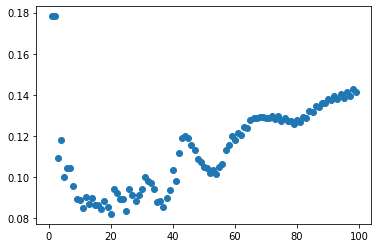

In [314]:
ths = range(1,100)

plt.figure()
plt.plot(ths, ch_msb0,'o')
plt.savefig('horizontal_correlation')

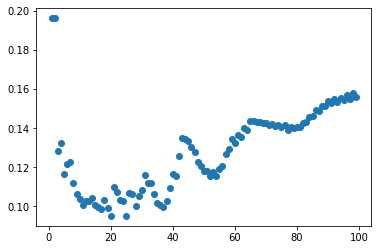

In [315]:
ths = range(1,100)

plt.figure()
plt.plot(ths, cv_msb0,'o')
plt.savefig('vertical_correlation')

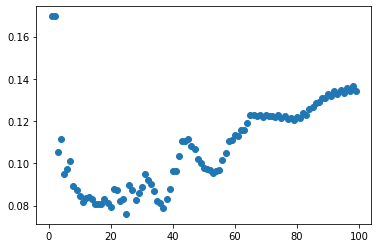

In [316]:
ths = range(1,100)

plt.figure()
plt.plot(ths, cd_msb0,'o')
plt.savefig('diagonal_correlation')

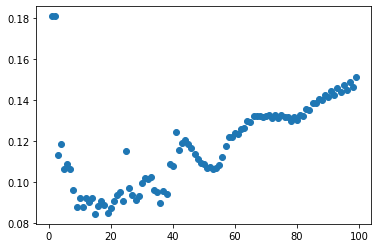

In [35]:
ths = range(1,100)

plt.figure()
plt.plot(ths, ch_msb1,'o')
plt.savefig('horizontal_correlation')

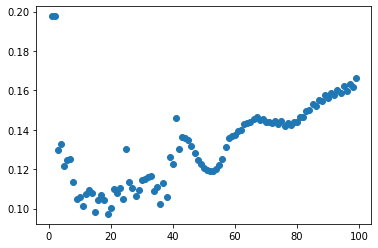

In [36]:
ths = range(1,100)

plt.figure()
plt.plot(ths, cv_msb1,'o')
plt.savefig('vertical_correlation')

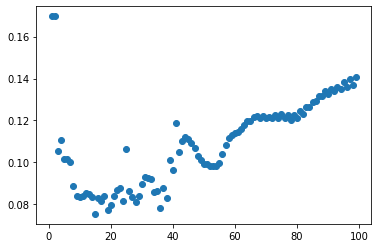

In [37]:
ths = range(1,100)

plt.figure()
plt.plot(ths, cd_msb1,'o')
plt.savefig('diagonal_correlation')

# DCT

In [9]:
all_nq_ac = []
for i in range(0,64):
    for j in range(0,64):
        blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]-128
        dct = cv2.dct(blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        
        all_nq_ac = np.append(all_nq_ac, nq_coef_ac)
        
#         fq_coef = np.round(dct/fqtable)
#         fq_coef_ac = np.delete(fq_coef, [0,0])
#         all_fq_ac = np.append(all_fq_ac, fq_coef_ac)

unique, counts = np.unique(all_nq_ac, return_counts=True)

maximum = int(np.max(unique))
minimum = int(np.min(unique))

border=int((maximum+minimum+1)/2) # first value in second half

pairs1 = list(range(minimum,border))
th = 4
pairing_rounds = np.floor(th/2)
pairs2 = []
for j in range(int(pairing_rounds)):
    n = int((maximum-border-(2*j+1))/th)
    for i in range(n+1):
        pairs2 = np.append(pairs2,border+2*j+i*th)
        pairs2 = np.append(pairs2,border+2*j+1+i*th)
    if (border+2*j+(n+1)*th) <= maximum:
        pairs2 = np.append(pairs2, border+2*j+(n+1)*th)
    
if np.mod(th,2):
    n = int((maximum-border-(th-1))/th)# 128+4+n*th =<255
    for i in range(n+1):
        pairs2 = np.append(pairs2,border+th-1+i*th)

In [10]:
#eve
height = 512
width = 512
eve_msb0_intensities = np.zeros([height,width])
eve_msb1_intensities = np.zeros([height,width])

for ii in range(0,64):
    for jj in range(0,64):
        blk = imf[8*ii:8*(ii+1), 8*jj:8*(jj+1)]-128
        dct = cv2.dct(blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        nq_coef_dc = nq_coef[0,0]
             
        
        eve_msb0 = np.zeros(63)
        eve_msb1 = np.zeros(63)
        for i in range(63):
            if nq_coef_ac[i] in pairs1:
                pos = np.argwhere(pairs1 == nq_coef_ac[i])

                if np.mod(pos,2):
                    eve_msb0_element = pairs2[pos]
                    eve_msb1_element = nq_coef_ac[i]
                else:
                    eve_msb0_element = nq_coef_ac[i]
                    eve_msb1_element = pairs2[pos]

                eve_msb0[i] = eve_msb0_element
                eve_msb1[i] = eve_msb1_element

                
            if nq_coef_ac[i] in pairs2:
                pos = np.argwhere(pairs2 == nq_coef_ac[i])

                if np.mod(pos,2):
                    eve_msb0_element = nq_coef_ac[i]
                    eve_msb1_element = pairs1[int(pos)]
                else:
                    eve_msb0_element = pairs1[int(pos)]
                    eve_msb1_element = nq_coef_ac[i]

                eve_msb0[i] = eve_msb0_element
                eve_msb1[i] = eve_msb1_element
        
        
        eve_msb0_coef1 = np.insert(eve_msb0, 0, nq_coef_dc)
        eve_msb0_coef = np.reshape(eve_msb0_coef1,[8,8])
        
        eve_msb0_intens1 = cv2.idct(eve_msb0_coef)
        eve_msb0_intens = np.round(eve_msb0_intens1)+128  
        eve_msb0_intensities [8*ii:8*(ii+1), 8*jj:8*(jj+1)]= eve_msb0_intens
        
        eve_msb1_coef1 = np.insert(eve_msb1, 0, nq_coef_dc)
        eve_msb1_coef = np.reshape(eve_msb1_coef1,[8,8])
        
        eve_msb1_intens1 = cv2.idct(eve_msb1_coef)
        eve_msb1_intens = np.round(eve_msb1_intens1)+128 
        eve_msb1_intensities [8*ii:8*(ii+1), 8*jj:8*(jj+1)]= eve_msb1_intens

In [12]:
eve_msb0_uint8 =eve_msb0_intensities.astype(np.uint8)
cv2.imshow('eve_msb0', eve_msb0_uint8)
filename = 'eve_msb0th'+str(th)+'.png'
cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

eve_msb1_uint8 =eve_msb1_intensities.astype(np.uint8)
cv2.imshow('eve_msb1', eve_msb0_uint8)
filename = 'eve_msb1th'+str(th)+'.png'
cv2.imwrite(os.path.join(os.path.expanduser('~'),'Desktop',filename), eve_msb0_uint8)
cv2.imwrite(filename, eve_msb0_uint8)
cv2.waitKey(1000)

-1

In [14]:
cv2.destroyAllWindows()

In [15]:
eve_msb0_dist_db = 10*np.log10(eve_distortion(eve_msb0_intensities))
eve_msb1_dist_db = 10*np.log10(eve_distortion(eve_msb1_intensities))
print(eve_msb0_dist_db)
print(eve_msb1_dist_db)

50.280155143540426
50.241842887354835
